In [99]:
import torch 
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from train import train
from torch.optim import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from train import train

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [101]:
data = pd.read_csv("/Users/maxkucher/shelling /specials.csv")
data = data.drop("Unnamed: 0", axis="columns")
data

,ev_ammount,aa_ammount,atgm_ammount,cl_shells_ammount,u_shells_ammount,fpv_shells_ammount,descision
0,0,1,0,0,0,0,4
1,0,1,0,0,0,1,3
2,0,1,0,0,0,2,3
3,0,1,0,0,0,3,3
4,0,1,0,0,1,0,4
...,...,...,...,...,...,...,...
3835,3,3,3,3,2,3,1
3836,3,3,3,3,3,0,1
3837,3,3,3,3,3,1,1
3838,3,3,3,3,3,2,1


In [102]:
data = pd.concat([data, data], axis="rows")

In [103]:
x = data.drop("descision", axis="columns")
y = data["descision"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

In [104]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x.values).to(device)
        self.y = torch.LongTensor(y.values).to(device)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [105]:
train_ds = MyDataset(x_train, y_train)
test_ds = MyDataset(x_test, y_test)

In [106]:
len(train_ds)

5760

In [107]:
train_ds[0]

(tensor([2., 2., 3., 0., 1., 2.]), tensor(2))

In [108]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))

In [109]:
train_dl

In [110]:
test_dl

In [111]:
x_train.shape

(5760, 6)

In [112]:
y_train.value_counts()

descision
1    2424
2    1729
0     927
3     639
4      41
Name: count, dtype: int64

In [113]:
class SpecialModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.linear1 = nn.Linear(in_features=6, out_features=24)
        self.bnorm1 = nn.BatchNorm1d(24)
        self.linear2 = nn.Linear(in_features=24, out_features=12)
        self.linear3 = nn.Linear(in_features=12, out_features=12)
        self.linear4 = nn.Linear(in_features=12, out_features=6)
        self.linear5 = nn.Linear(in_features=6, out_features=num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)

        return out

    def predict(self, x, device="cpu"):
        x = torch.FloatTensor(x).to(device)
        with torch.no_grad():
            y_pred = torch.softmax(self.forward(x), dim=-1)
        
        return y_pred
    
model = SpecialModel().to(device)
model

SpecialModel(
  (linear1): Linear(in_features=6, out_features=24, bias=True)
  (bnorm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=24, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=12, bias=True)
  (linear4): Linear(in_features=12, out_features=6, bias=True)
  (linear5): Linear(in_features=6, out_features=5, bias=True)
)

In [114]:
%pip install -q torchsummary

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [115]:
from torchsummary import summary

summary(model, input_size=(6,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             168
       BatchNorm1d-2                   [-1, 24]              48
            Linear-3                   [-1, 12]             300
            Linear-4                   [-1, 12]             156
            Linear-5                    [-1, 6]              78
            Linear-6                    [-1, 5]              35
Total params: 785
Trainable params: 785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [116]:
optimizer = Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [117]:
history = train(model, optimizer, loss_func, train_dl, test_dl, epochs=50, metrics=[accuracy_score], 
                device=device, task="multiclass")

Epoch    1    0sec	loss:        1.4	val_loss:      0.985	accuracy_score:      0.372	val_accuracy_score:      0.579	
Epoch    2    0sec	loss:      0.726	val_loss:      0.569	accuracy_score:      0.728	val_accuracy_score:      0.776	
Epoch    3    0sec	loss:       0.56	val_loss:      0.505	accuracy_score:      0.772	val_accuracy_score:      0.778	
Epoch    4    0sec	loss:      0.528	val_loss:      0.469	accuracy_score:      0.789	val_accuracy_score:      0.807	
Epoch    5    0sec	loss:      0.494	val_loss:       0.43	accuracy_score:      0.792	val_accuracy_score:      0.815	
Epoch    6    0sec	loss:      0.451	val_loss:      0.408	accuracy_score:      0.805	val_accuracy_score:      0.823	
Epoch    7    0sec	loss:      0.432	val_loss:      0.374	accuracy_score:      0.815	val_accuracy_score:      0.834	
Epoch    8    0sec	loss:      0.416	val_loss:      0.356	accuracy_score:      0.811	val_accuracy_score:      0.832	
Epoch    9    0sec	loss:       0.39	val_loss:      0.341	accuracy_score:

In [118]:
loader = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

predicted_classes = torch.argmax(y_pred, dim=1).cpu().numpy()

print(predicted_classes)

[3 0 1 ... 1 2 0]


[]

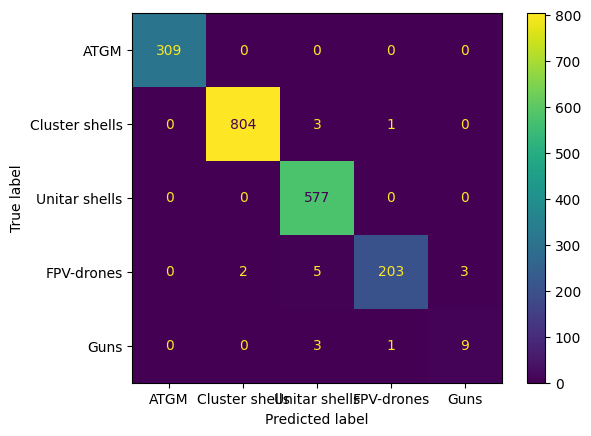

In [124]:
commands = ["ATGM", "Cluster shells", "Unitar shells", "FPV-drones", "Guns"]
ConfusionMatrixDisplay.from_predictions(y_test, predicted_classes, display_labels=commands)
plt.plot()

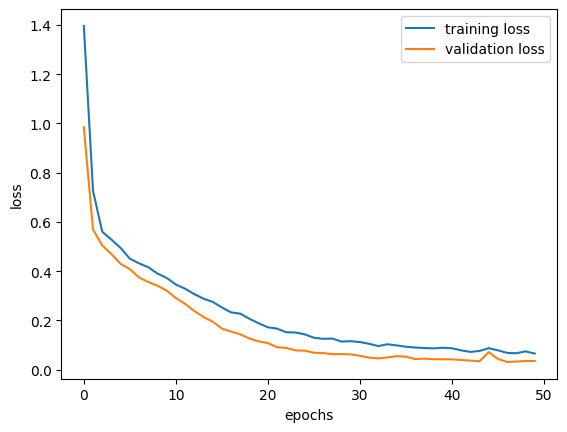

In [120]:
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [121]:
data[data["descision"] == 4] 

,ev_ammount,aa_ammount,atgm_ammount,cl_shells_ammount,u_shells_ammount,fpv_shells_ammount,descision
0,0,1,0,0,0,0,4
4,0,1,0,0,1,0,4
16,0,1,0,1,0,0,4
20,0,1,0,1,1,0,4
256,0,2,0,0,0,0,4
260,0,2,0,0,1,0,4
272,0,2,0,1,0,0,4
276,0,2,0,1,1,0,4
512,0,3,0,0,0,0,4
768,1,0,0,0,0,0,4


In [125]:
x = torch.FloatTensor([0, 2, 0, 0, 0, 0]).to(device)
x = x.unsqueeze(0)
model.eval()

with torch.no_grad():
    res = model(x)

t_x = torch.argmax(res)
t_array = np.array(t_x)


print(commands[t_array])

Guns


In [126]:
torch.save(model, "specials.pt")

In [129]:
m = torch.load("specials.pt")

summary(m, input_size=(6,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             168
       BatchNorm1d-2                   [-1, 24]              48
            Linear-3                   [-1, 12]             300
            Linear-4                   [-1, 12]             156
            Linear-5                    [-1, 6]              78
            Linear-6                    [-1, 5]              35
Total params: 785
Trainable params: 785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [130]:
torch.save(model.state_dict(), "specials.pt")